# Adelaide Weather Data

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
import math

# The Adelaide Weather Data

In [2]:
adei_data = pd.read_csv('/course/data/a2/weather/weather_adelaide.csv')
adei_data.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-02-1,17.6,25.6,0.0,NaN,NaN,SW,46.0,13:25,19.2,...,NaN,S,7,1014.7,24.4,38,NaN,SSW,22,1013.9
1,2021-02-2,13.2,24.5,0.0,NaN,NaN,S,37.0,13:58,18.1,...,NaN,SSE,11,1019.2,23.7,33,NaN,S,20,1017.0
2,2021-02-3,13.0,28.6,0.0,NaN,NaN,W,26.0,13:02,18.6,...,NaN,N,6,1014.3,26.1,31,NaN,WSW,13,1009.2
3,2021-02-4,18.3,24.6,0.0,NaN,NaN,WNW,43.0,10:04,23.4,...,NaN,NE,9,1000.5,19.1,73,NaN,NNE,17,998.9
4,2021-02-5,12.8,19.4,15.6,NaN,NaN,NW,61.0,15:03,16.0,...,NaN,N,24,999.1,18.5,73,NaN,NNW,30,994.5


In [3]:
adei_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               424 non-null    object 
 1   Minimum temperature (°C)           424 non-null    float64
 2   Maximum temperature (°C)           422 non-null    float64
 3   Rainfall (mm)                      417 non-null    float64
 4   Evaporation (mm)                   0 non-null      float64
 5   Sunshine (hours)                   0 non-null      float64
 6   Direction of maximum wind gust     416 non-null    object 
 7   Speed of maximum wind gust (km/h)  416 non-null    float64
 8   Time of maximum wind gust          416 non-null    object 
 9   9am Temperature (°C)               424 non-null    float64
 10  9am relative humidity (%)          424 non-null    int64  
 11  9am cloud amount (oktas)           0 non-null      float64

Summary:
- The 'Evaporation', 'Sunshine', '9am cloud amount', and '3pm cloud amount' Columns has all values as 'Null'

In [4]:
# Remove all-null columns
adei_data = adei_data.dropna(how='all', axis=1)

# The Demand For South Australia

In [5]:
demand = pd.read_csv('/course/data/a2/weather/price_demand_data.csv')
sa_demand = demand[demand['REGION'] == 'SA1']
sa_demand.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE
2688,SA1,2021/02/01 00:30:00,1367.95,False
2689,SA1,2021/02/01 01:00:00,1299.76,False
2690,SA1,2021/02/01 01:30:00,1267.86,False
2691,SA1,2021/02/01 02:00:00,1213.06,False
2692,SA1,2021/02/01 02:30:00,1167.73,False


In [6]:
sa_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 2688 to 235103
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REGION          60000 non-null  object 
 1   SETTLEMENTDATE  60000 non-null  object 
 2   TOTALDEMAND     60000 non-null  float64
 3   PRICESURGE      60000 non-null  bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 1.9+ MB


Summary:
- The demand for South Australia does not contain any null cells or any missing data. However, all values for the PRICESURGE attribute are false.

## Pre-processing the South Australia Demand  

In [7]:
#Make the sa_demand have the date cell using regex
date_pattern = r'(\d{4}\/\d{2}\/\d{1,2})'

# Apply it to the demand dataframe
sa_demand['Date'] = sa_demand['SETTLEMENTDATE'].str.extract(date_pattern)
# Make sure that the dates are the standard Pandas DateTime to allow for comparison and joining
sa_demand['Date'] = pd.to_datetime(sa_demand['Date'])

# Find the total seconds between each timeframe
sa_demand["diff_time"] = pd.to_datetime(sa_demand['SETTLEMENTDATE']).diff(periods = 1).dt.total_seconds()
# standardize the timespans of the data (30 minutes/1800 seconds) to allow for consistancies for consumption calculations
sa_demand["diff_time"] = sa_demand["diff_time"].replace(np.nan, 1800)

#we calculate the consumption and change it to MWH:
sa_demand['CONSUMPTION'] = sa_demand['TOTALDEMAND']*sa_demand["diff_time"]
sa_demand['CONSUMPTION'] = sa_demand['CONSUMPTION']*(1e6)*(2.7777e-10)

sa_demand.head()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\2086143991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_demand['Date'] = sa_demand['SETTLEMENTDATE'].str.extract(date_pattern)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\2086143991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_demand['Date'] = pd.to_datetime(sa_demand['Date'])
C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\2086143991.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE,Date,diff_time,CONSUMPTION
2688,SA1,2021/02/01 00:30:00,1367.95,False,2021-02-01,1800.0,683.955849
2689,SA1,2021/02/01 01:00:00,1299.76,False,2021-02-01,1800.0,649.861803
2690,SA1,2021/02/01 01:30:00,1267.86,False,2021-02-01,1800.0,633.912250
2691,SA1,2021/02/01 02:00:00,1213.06,False,2021-02-01,1800.0,606.513017
2692,SA1,2021/02/01 02:30:00,1167.73,False,2021-02-01,1800.0,583.848652


In [8]:
# Sum all of the consumption for each day
sa_date_demand = sa_demand.groupby('Date').sum()
sa_date_demand = sa_date_demand.reset_index()
sa_date_demand

,Date,TOTALDEMAND,PRICESURGE,diff_time,CONSUMPTION
0,2021-02-01,52873.22,0,84600.0,26435.869775
1,2021-02-02,51454.67,0,86400.0,25726.614635
2,2021-02-03,53927.60,0,86400.0,26963.045014
3,2021-02-04,62652.62,0,86400.0,31325.432863
4,2021-02-05,53078.36,0,86400.0,26538.436903
...,...,...,...,...,...
406,2022-03-14,397311.77,0,86400.0,33108.387106
407,2022-03-15,454855.30,1,86400.0,37903.547004
408,2022-03-16,462750.74,0,86400.0,38561.481915
409,2022-03-17,393968.53,0,86400.0,32829.791573


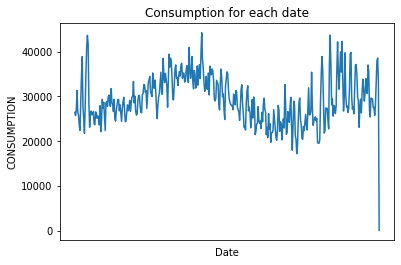

In [9]:
#plot the average demand for each date for nsw
#create a subplot
fig, ax = plt.subplots()

#plot the bar plot
ax.plot([str(x) for x in sa_date_demand.index], sa_date_demand['CONSUMPTION'])

#add lable and title
ax.set_xlabel('Date')
ax.set_ylabel('CONSUMPTION')
ax.set_title('Consumption for each date')
plt.xticks([])
plt.show()
plt.close()

An outlier can be found in the last date of the demand dataset. Looking through the data, this can be because the data for that day is incomplete Therefore, we will substitute that data point with the mean value of the consumption.

In [10]:
sa_date_demand['CONSUMPTION'][sa_date_demand['CONSUMPTION'].idxmin()] = sa_date_demand.mean()["CONSUMPTION"]

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\1662195836.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  sa_date_demand['CONSUMPTION'][sa_date_demand['CONSUMPTION'].idxmin()] = sa_date_demand.mean()["CONSUMPTION"]
C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\1662195836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_date_demand['CONSUMPTION'][sa_date_demand['CONSUMPTION'].idxmin()] = sa_date_demand.mean()["CONSUMPTION"]


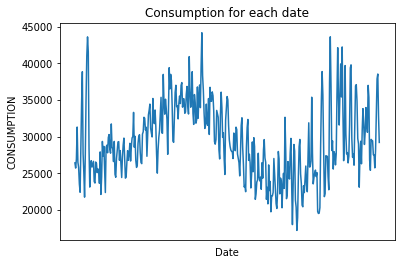

In [11]:
#plot the average demand for each date for nsw
#create a subplot
fig, ax = plt.subplots()

#plot the bar plot
ax.plot([str(x) for x in sa_date_demand.index], sa_date_demand['CONSUMPTION'])

#add lable and title
ax.set_xlabel('Date')
ax.set_ylabel('CONSUMPTION')
ax.set_title('Consumption for each date')
plt.xticks([])
plt.show()
plt.close()

Because the demand for VIC per day has less row than the weather data for the melboure, we merge the weather data to the demand data.


# Merge the Adelaide weather dataset and the SA demand dataset and pre-processing the merged_data

In [12]:
#this function will change the direction in to 1-16 (numeric the direction)
def numeric_wind_direction(name_col, weather_data):
    weather_data[name_col] = OrdinalEncoder().fit_transform(weather_data[[name_col]])

## Performing mergeing and pre_processing

In [13]:
#change the type of Date columns into datetime before mergeing
adei_data['Date'] = pd.to_datetime(adei_data['Date'])
adei_data.head()

#merge the demand to the weather dataset
original_merged_data = pd.merge(adei_data, sa_date_demand, how='left')

#numric the direction of the wind
numeric_wind_direction('Direction of maximum wind gust ',original_merged_data)
numeric_wind_direction('3pm wind direction',original_merged_data)
numeric_wind_direction('9am wind direction',original_merged_data)

#convert the time in maximum wind gust to the total seconds
original_merged_data['Time of maximum wind gust'] = '00:' + original_merged_data['Time of maximum wind gust']
original_merged_data['Time of maximum wind gust'] = pd.to_timedelta(original_merged_data['Time of maximum wind gust']).dt.total_seconds()

#change the Calm value in the dataframe to np.nan
original_merged_data = original_merged_data.replace([np.nan, np.inf, -np.inf, 'Calm'], np.nan)

#because as we obsevered the Dtype of wind speed is an object
#so we change it into float64 which will be identical for fillna working
original_merged_data['9am wind speed (km/h)'] = original_merged_data['9am wind speed (km/h)'].astype(np.float64)
original_merged_data['3pm wind speed (km/h)'] = original_merged_data['3pm wind speed (km/h)'].astype(np.float64)

#fill the nan value in the wind direction by the mode value 
#rather than the mean value in those weather condition
original_merged_data['9am wind direction'] = original_merged_data['9am wind direction'].fillna(original_merged_data['9am wind direction'].mode())
original_merged_data['3pm wind direction'] = original_merged_data['3pm wind direction'].fillna(original_merged_data['9am wind direction'].mode())
original_merged_data['Direction of maximum wind gust '] = original_merged_data['Direction of maximum wind gust '].fillna(original_merged_data['Direction of maximum wind gust '].mode())

#fill the nan value with the mean value for the rest of the weather condition
original_merged_data = original_merged_data.fillna(original_merged_data.mean())

# we reset the index
original_merged_data = original_merged_data.reset_index()
original_merged_data = original_merged_data.drop(['index'], axis=1)

original_merged_data.head()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\1451153978.py:32: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  original_merged_data = original_merged_data.fillna(original_merged_data.mean())


,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),9am wind direction,...,9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND,PRICESURGE,diff_time,CONSUMPTION
0,2021-02-01,17.6,25.6,0.0,12.0,46.0,805.0,19.2,57,9.0,...,1014.7,24.4,38,12.0,22.0,1013.9,52873.22,0.0,84600.0,26435.869775
1,2021-02-02,13.2,24.5,0.0,8.0,37.0,838.0,18.1,56,11.0,...,1019.2,23.7,33,9.0,20.0,1017.0,51454.67,0.0,86400.0,25726.614635
2,2021-02-03,13.0,28.6,0.0,13.0,26.0,782.0,18.6,52,4.0,...,1014.3,26.1,31,16.0,13.0,1009.2,53927.60,0.0,86400.0,26963.045014
3,2021-02-04,18.3,24.6,0.0,14.0,43.0,604.0,23.4,37,5.0,...,1000.5,19.1,73,6.0,17.0,998.9,62652.62,0.0,86400.0,31325.432863
4,2021-02-05,12.8,19.4,15.6,7.0,61.0,903.0,16.0,61,4.0,...,999.1,18.5,73,7.0,30.0,994.5,53078.36,0.0,86400.0,26538.436903


## As this section is for consumption, remove weather features that is only applicable to specific time frames

In [14]:
# DROP ALL COLUMNS WITH TIMELY (9AM AND 3PM) WEATHER FEATURES
consumption_merged_data = original_merged_data[original_merged_data.columns.drop(list(original_merged_data.filter(regex='(?=.*(9am|3pm))')))]

#drop out some attributes which are unrelated
consumption_merged_data = consumption_merged_data.drop(['PRICESURGE','TOTALDEMAND', 'diff_time', 'Date'], axis=1)




In [15]:
consumption_merged_data.head()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
0,17.6,25.6,0.0,12.0,46.0,805.0,26435.869775
1,13.2,24.5,0.0,8.0,37.0,838.0,25726.614635
2,13.0,28.6,0.0,13.0,26.0,782.0,26963.045014
3,18.3,24.6,0.0,14.0,43.0,604.0,31325.432863
4,12.8,19.4,15.6,7.0,61.0,903.0,26538.436903


# Plot the correlation between each attribute in the merged dataframe 

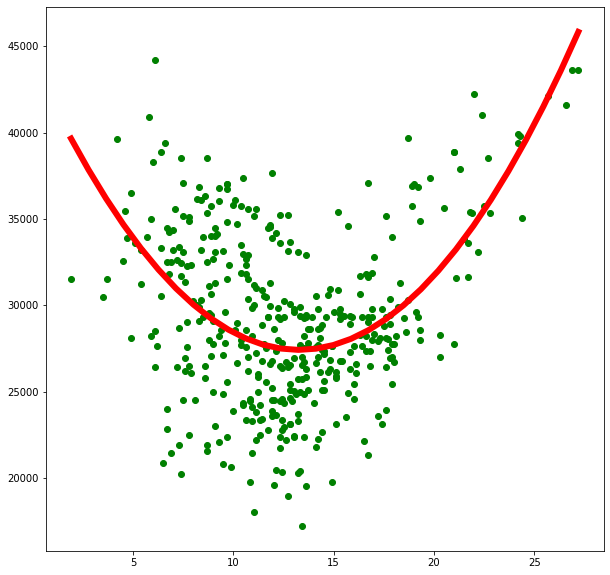

In [16]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

ax.scatter(consumption_merged_data['Minimum temperature (°C)'], consumption_merged_data['CONSUMPTION'], c='g')
z = np.polyfit(consumption_merged_data['Minimum temperature (°C)'], consumption_merged_data['CONSUMPTION'],2)
curve = np.array(z)
x = np.linspace(min(consumption_merged_data['Minimum temperature (°C)']),max(consumption_merged_data['Minimum temperature (°C)']),30)
y = [np.polyval(curve, i) for i in x]
ax.plot(x,y, 'r', linewidth = 6)

plt.show()
plt.close()

In [17]:
corr = consumption_merged_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
Minimum temperature (°C),1.000000,0.763316,-0.102642,-0.157097,0.142314,-0.024636,0.103641
Maximum temperature (°C),0.763316,1.000000,-0.240984,-0.194177,-0.050951,0.069422,-0.076214
Rainfall (mm),-0.102642,-0.240984,1.000000,0.076657,0.238164,-0.012344,0.148156
Direction of maximum wind gust,-0.157097,-0.194177,0.076657,1.000000,-0.017447,0.070811,-0.120428
Speed of maximum wind gust (km/h),0.142314,-0.050951,0.238164,-0.017447,1.000000,-0.020699,-0.047486
Time of maximum wind gust,-0.024636,0.069422,-0.012344,0.070811,-0.020699,1.000000,0.019590
CONSUMPTION,0.103641,-0.076214,0.148156,-0.120428,-0.047486,0.019590,1.000000


As seen by the data and using Pearson Correlation, it seems that there is no correlation between the CONSUMPTION and the weather condition.

## Reason for no correlation between some weather condition and consumption using the Pearson Correlation Method 

The relation between the weather condition and consumption does not follow a linear relationship. Therefore, the pearson correlation method is not suitable.

## Observed the correlation in Normalized Mutual Information method

In [18]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_data = consumption_merged_data.copy()
for name in consumption_merged_data:
    
    discrete_data[name] = equal_width.fit_transform(consumption_merged_data[[name]])

corr = discrete_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
Minimum temperature (°C),1.000000,0.233125,0.079458,0.142118,0.129877,0.143633,0.194631
Maximum temperature (°C),0.233125,1.000000,0.100761,0.155829,0.129737,0.148297,0.209488
Rainfall (mm),0.079458,0.100761,1.000000,0.073354,0.107586,0.073019,0.084145
Direction of maximum wind gust,0.142118,0.155829,0.073354,1.000000,0.151669,0.220549,0.141629
Speed of maximum wind gust (km/h),0.129877,0.129737,0.107586,0.151669,1.000000,0.155353,0.130843
Time of maximum wind gust,0.143633,0.148297,0.073019,0.220549,0.155353,1.000000,0.151373
CONSUMPTION,0.194631,0.209488,0.084145,0.141629,0.130843,0.151373,1.000000


The features which have moderate correlation are:
- Minimum temperature (°C)
- Maximum temperature (°C)
- Time of maximum wind gust (km/h)

# Applying Feature Selection by using Chi-square and Mutual Information

## Performing Chi-square to observe the correlation

In [19]:
# set our alpha significance level
ALPHA = 0.05

# get our features and class label
features = discrete_data[[x for x in discrete_data]]
class_label = discrete_data['CONSUMPTION']

In [20]:
filtered_features = []

for feature in features:
    cont_table = pd.crosstab(class_label, features[feature])
    chi2_val, p, dof, expected = stats.chi2_contingency(cont_table.values, correction=False)
    #ask about correction again
    
    print(f'Chi2 value for feature "{feature}": {chi2_val:.4f}')
    
    if(p < ALPHA): 
        filtered_features.append(feature)
        print(f'Reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
    else:
        print(f'Fail to reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
        
print('Feature set after filtering with Chi-square test:', filtered_features)

Chi2 value for feature "Minimum temperature (°C)": 915.3409
Reject the Null Hypothesis for feature "Minimum temperature (°C)", p-value 0.0000

Chi2 value for feature "Maximum temperature (°C)": 852.3750
Reject the Null Hypothesis for feature "Maximum temperature (°C)", p-value 0.0000

Chi2 value for feature "Rainfall (mm)": 186.9110
Fail to reject the Null Hypothesis for feature "Rainfall (mm)", p-value 0.5498

Chi2 value for feature "Direction of maximum wind gust ": 368.9731
Reject the Null Hypothesis for feature "Direction of maximum wind gust ", p-value 0.0006

Chi2 value for feature "Speed of maximum wind gust (km/h)": 395.3043
Fail to reject the Null Hypothesis for feature "Speed of maximum wind gust (km/h)", p-value 0.1033

Chi2 value for feature "Time of maximum wind gust": 387.2387
Fail to reject the Null Hypothesis for feature "Time of maximum wind gust", p-value 0.1639

Chi2 value for feature "CONSUMPTION": 8056.0000
Reject the Null Hypothesis for feature "CONSUMPTION", p-va

## Performing Mututal Information to obsevered the correlation

In [21]:
mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "Minimum temperature (°C)": 0.5146
MI value for feature "Maximum temperature (°C)": 0.5611
MI value for feature "Rainfall (mm)": 0.1399
MI value for feature "Direction of maximum wind gust ": 0.3721
MI value for feature "Speed of maximum wind gust (km/h)": 0.3364
MI value for feature "Time of maximum wind gust": 0.3962
MI value for feature "CONSUMPTION": 2.6756


Choose the top 3 features that has the highest mutual information from the dataset

In [22]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('Time of maximum wind gust', 0.39616257563373836),
 ('Minimum temperature (°C)', 0.5146162556371452),
 ('Maximum temperature (°C)', 0.5611190916698308),
 ('CONSUMPTION', 2.6755501485433753)]

Feature selected by mutual information method:
- Maximum temperature (°C)
- Minimum temperature (°C)
- Time of maximum wind gust

## Feature Selection

- After observing the feature selected by two method in other city, we decide to keep using the mutual information for this model. However, Chi_square tends to choose most of the features in weather conditions.

## Plotting the Selected Features

In [23]:
features = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Time of maximum wind gust', 'CONSUMPTION']
consumption_merged_data = consumption_merged_data[features]

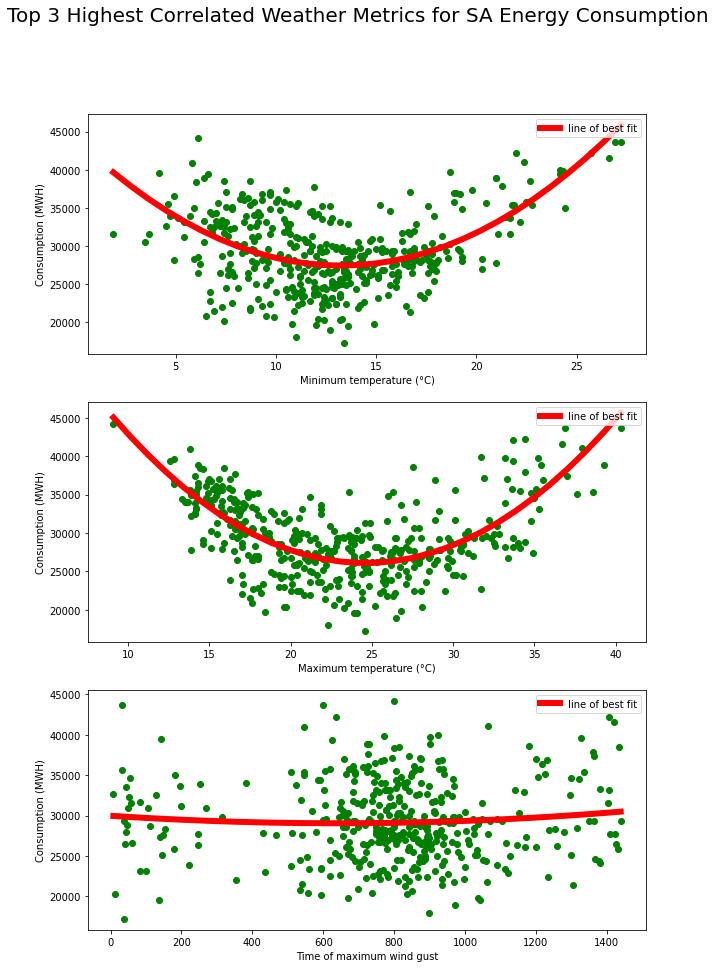

In [24]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,15)
fig, ax = plt.subplots(3)

for i in range (3):

    ax[i].scatter(consumption_merged_data.iloc[:,i], consumption_merged_data['CONSUMPTION'], c='g')
    ax[i].set_xlabel(consumption_merged_data.columns[i])
    ax[i].set_ylabel("Consumption (MWH)")
    

    #draw line of best fit for actual value of y
    z = np.polyfit(consumption_merged_data.iloc[:,i], consumption_merged_data['CONSUMPTION'], 2)
    curve_1 = np.array(z)
    x = np.linspace(min(consumption_merged_data.iloc[:,i]),max(consumption_merged_data.iloc[:,i]),30)
    y_1 = [np.polyval(curve_1, i) for i in x]
    ax[i].plot(x,y_1, 'r', linewidth = 6, label = "line of best fit")

    #adding lengend for the graph
    ax[i].legend(loc = "upper right")


plt.suptitle('Top 3 Highest Correlated Weather Metrics for SA Energy Consumption',fontsize=20)

plt.savefig('sa_selected_plot.png')
plt.show()
plt.close()

# Apply supervised Machine Learning

## Keep the feature that we selected and split the data into training and testing

In [25]:
features  = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Time of maximum wind gust']

X = consumption_merged_data[features]
Y = consumption_merged_data['CONSUMPTION']

Create the train and test data

In [26]:
#split the data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=10)

## K-NN Regression 

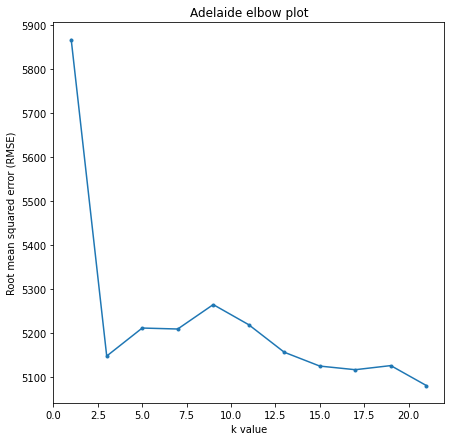

In [27]:
RMSE = []
for k in range(1,23,2):
    adei_knn_model = KNeighborsRegressor(n_neighbors=k)
    adei_knn_model.fit(X_train,Y_train)
    rmse = -cross_val_score(adei_knn_model, X_train, Y_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE.append(np.mean(rmse))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]
ax.plot(k,RMSE, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root mean squared error (RMSE)")
ax.set_title("Adelaide elbow plot")

plt.savefig("adei_elbow.png")
plt.show()
plt.close()


According to the elbow method, the k value that we should choose for the KNN moddel is 3, as it has the smallest mean squared error. However, as 3 is a very small number, it could be too sensitive to outliers, so the model shall use 5, which still has a reasonably small mean squared error.

In [28]:
adei_knn_model = KNeighborsRegressor(n_neighbors=3)
adei_knn_model.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=3)

## Prediction

Using the KNN model, predict using the text dataset

In [29]:
y_predict = adei_knn_model.predict(X_test)

In [30]:
print('r2: ' , metrics.r2_score(Y_test, y_predict))
RMSE = math.sqrt(metrics.mean_squared_error(Y_test, y_predict))
print("RMSE: ",  RMSE)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE/np.mean(Y_test))*100), "%")
MAE = metrics.mean_absolute_error(Y_test, y_predict)
print("MAE: ", MAE)
print("Percentage of error compare to average of actual value: ", round((MAE/np.mean(Y_test))*100), "%")

r2:  0.069308614113612
RMSE:  4734.974204019465
Percentage of RMSE compare to average of actual value:  16 %
MAE:  3831.912692700965
Percentage of error compare to average of actual value:  13 %


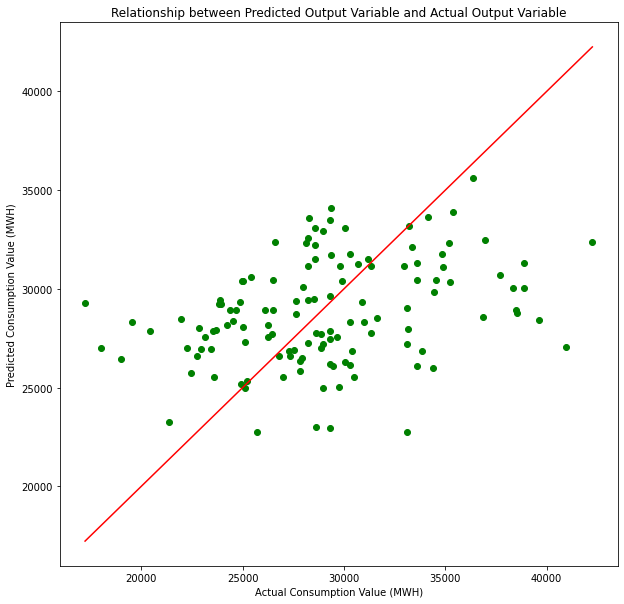

In [31]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

ax.scatter(Y_test, y_predict, c='g')

#plot the line y = x
x = np.linspace(min(Y_test), max(Y_test), 30)
ax.plot(x,x, 'r')


ax.set_xlabel("Actual Consumption Value (MWH)")
ax.set_ylabel("Predicted Consumption Value (MWH)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable')

plt.savefig('Sample_adei_ytestvstrain.png')
plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the consumption

In [32]:
def observe_prediction(X_test, Y_test, y_predict, title, output_name):

    #create a subplot
    plt.rcParams["figure.figsize"] = (10,15)
    fig, ax = plt.subplots(3)


    for i in range (3):
        ax[i].scatter(X_test.iloc[:,i], Y_test, label = "Actual", c='g')
        ax[i].scatter(X_test.iloc[:,i], pd.Series(y_predict), label = "Predict", c='coral')
        ax[i].set_xlabel(X_test.columns[i])
        ax[i].set_ylabel("Consumption")
        
        #adding lengend for the graph
        ax[i].legend(loc = "upper right")



    plt.suptitle(title,fontsize=20)

    plt.savefig(output_name)
    plt.show()
    plt.close()

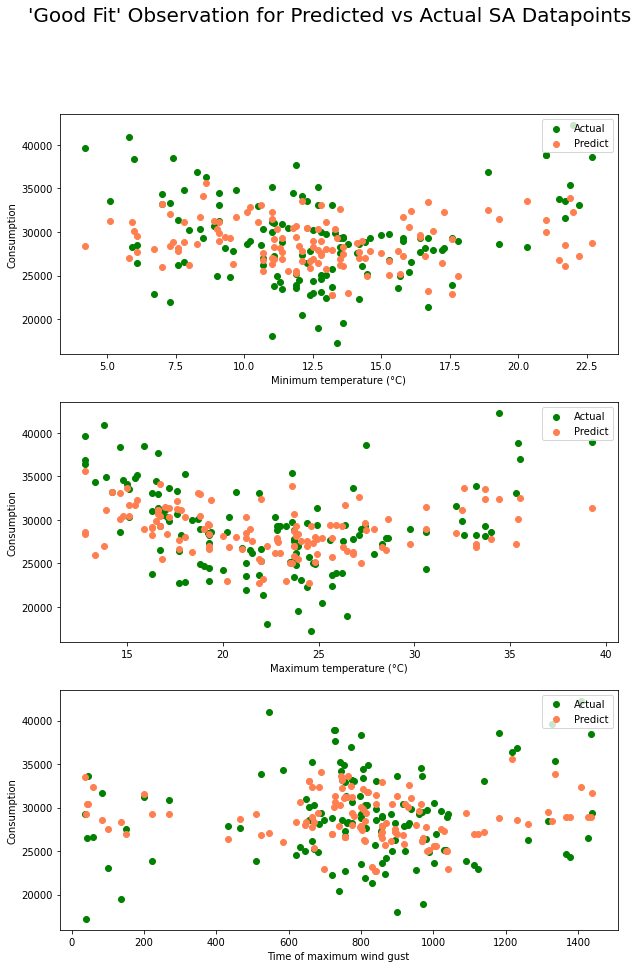

In [33]:
output_name = 'observing_predict_plot_adei.png'
title = "'Good Fit' Observation for Predicted vs Actual SA Datapoints"
observe_prediction(X_test, Y_test, y_predict, title, output_name)

# Time-specific Demand and Weather Conditions 

In [34]:
sa_demand.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE,Date,diff_time,CONSUMPTION
2688,SA1,2021/02/01 00:30:00,1367.95,False,2021-02-01,1800.0,683.955849
2689,SA1,2021/02/01 01:00:00,1299.76,False,2021-02-01,1800.0,649.861803
2690,SA1,2021/02/01 01:30:00,1267.86,False,2021-02-01,1800.0,633.912250
2691,SA1,2021/02/01 02:00:00,1213.06,False,2021-02-01,1800.0,606.513017
2692,SA1,2021/02/01 02:30:00,1167.73,False,2021-02-01,1800.0,583.848652


## Energy demand for 9am and 3pm timeframes

In [35]:
time_pattern = r'(\d{2}:\d{2}:\d{2})'
sa_demand['Time'] = sa_demand['SETTLEMENTDATE'].str.extract(time_pattern)

sa_9am = sa_demand.loc[sa_demand['Time'] == "09:00:00"]
sa_9am= sa_9am.reset_index()
sa_9am = sa_9am.drop(['index'], axis = 1)
sa_3pm = sa_demand.loc[sa_demand['Time'] == "15:00:00"]
sa_3pm= sa_3pm.reset_index()
sa_3pm = sa_3pm.drop(['index'], axis = 1)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11248\2358114809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sa_demand['Time'] = sa_demand['SETTLEMENTDATE'].str.extract(time_pattern)


For the demand datasets which only includes demand from 9am and 3pm timestamps, all unrelated columns should be dropped

In [36]:
original_merged_data = original_merged_data.drop(['PRICESURGE','TOTALDEMAND', 'diff_time','CONSUMPTION'], axis =1)

## Relationship between 9am Weather Conditions and Demand at 9am

In [37]:
#merge the demand at 9am to the weather dataset which is already pre-processed
merged_9am_data = pd.merge(original_merged_data, sa_9am, how='left')

#keeping 9am feature
feature_9am = []

for col in merged_9am_data:
    if '9am' in col:
        feature_9am.append(col)

#still keeping the totaldemand columns
feature_9am.append("TOTALDEMAND")
merged_9am_data = merged_9am_data[feature_9am]

#fill out some nan value due to the merge to the left 
#because the number of the date in weather data is more than demand data
merged_9am_data['TOTALDEMAND'] = merged_9am_data['TOTALDEMAND'].fillna(merged_9am_data['TOTALDEMAND'].mean())

merged_9am_data.head()

,9am Temperature (°C),9am relative humidity (%),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),TOTALDEMAND
0,19.2,57,9.0,7.0,1014.7,1303.11
1,18.1,56,11.0,11.0,1019.2,1192.76
2,18.6,52,4.0,6.0,1014.3,1031.04
3,23.4,37,5.0,9.0,1000.5,1472.10
4,16.0,61,4.0,24.0,999.1,833.27


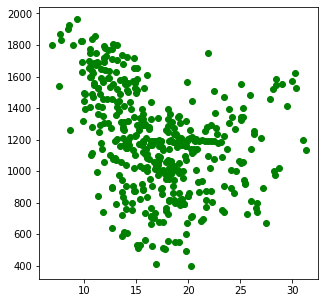

In [38]:
#create a subplot
plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()

ax.scatter(merged_9am_data['9am Temperature (°C)'], merged_9am_data['TOTALDEMAND'], c='g')
plt.show()
plt.close()

## NMI for 9am

In [39]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_9am_data = merged_9am_data.copy()
for name in merged_9am_data:
    
    discrete_9am_data[name] = equal_width.fit_transform(merged_9am_data[[name]])

corr = discrete_9am_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,9am Temperature (°C),9am relative humidity (%),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),TOTALDEMAND
9am Temperature (°C),1.000000,0.222484,0.159278,0.120427,0.169886,0.206748
9am relative humidity (%),0.222484,1.000000,0.160134,0.110092,0.157009,0.174037
9am wind direction,0.159278,0.160134,1.000000,0.185316,0.120692,0.154263
9am wind speed (km/h),0.120427,0.110092,0.185316,1.000000,0.110384,0.106126
9am MSL pressure (hPa),0.169886,0.157009,0.120692,0.110384,1.000000,0.148801
TOTALDEMAND,0.206748,0.174037,0.154263,0.106126,0.148801,1.000000


### Feature Selection using Mutual Information

In [40]:
# get our features and class label
features = discrete_9am_data[[x for x in discrete_9am_data]]
class_label = discrete_9am_data['TOTALDEMAND']

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "9am Temperature (°C)": 0.5701
MI value for feature "9am relative humidity (%)": 0.4822
MI value for feature "9am wind direction": 0.4189
MI value for feature "9am wind speed (km/h)": 0.2686
MI value for feature "9am MSL pressure (hPa)": 0.4016
MI value for feature "TOTALDEMAND": 2.7881


In [41]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('9am wind direction', 0.41885316515808624),
 ('9am relative humidity (%)', 0.4821623967041174),
 ('9am Temperature (°C)', 0.570116626564559),
 ('TOTALDEMAND', 2.788125567673712)]

Selected Feature for Machine Learning are:
- 9am MSL pressure (hPa)
- 9am relative humidity (%)
- 9am Temperature (°C)

### KNN Regressor for 9am dataset

In [42]:
#keep the selected feature in the dataframe
features_9am  = ['9am MSL pressure (hPa)', '9am relative humidity (%)', '9am Temperature (°C)']

X_9am = merged_9am_data[features_9am]
Y_9am = merged_9am_data['TOTALDEMAND']

In [43]:
#split the data into test and train
X_9am_train, X_9am_test, Y_9am_train, Y_9am_test = train_test_split(X_9am,Y_9am, test_size=0.3, random_state=20)

Elbow method. Testing with several different integers, choose the value that has the smallest mean square error to be used for k 

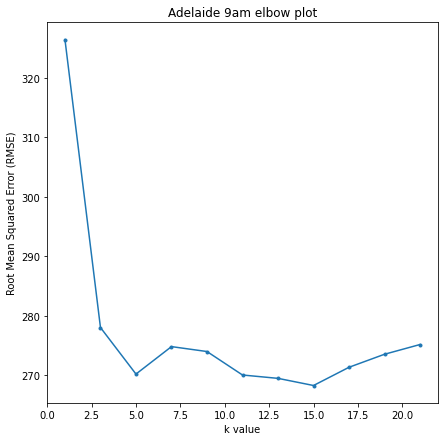

In [44]:
RMSE_9am = []
for k in range(1,23,2):
    adei_9am_knn_model = KNeighborsRegressor(n_neighbors=k)
    adei_9am_knn_model.fit(X_9am_train,Y_9am_train)
    rmse_9am = -cross_val_score(adei_9am_knn_model, X_9am_train, Y_9am_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE_9am.append(np.mean(rmse_9am))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]

ax.plot(k,RMSE_9am, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root Mean Squared Error (RMSE)")
ax.set_title('Adelaide 9am elbow plot')

plt.show()
plt.close()

5 has the smallest mean square error, so k = 5

In [45]:
adei_9am_knn_model = KNeighborsRegressor(n_neighbors=5)
adei_9am_knn_model.fit(X_9am_train,Y_9am_train)

y_9am_predict = adei_9am_knn_model.predict(X_9am_test)
print('r2: ', metrics.r2_score(Y_9am_test, y_9am_predict))
RMSE_9am = math.sqrt(metrics.mean_squared_error(Y_9am_test, y_9am_predict))
print("RMSE: ",  RMSE_9am)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE_9am/np.mean(Y_9am_test))*100), "%")
MAE_9am = metrics.mean_absolute_error(Y_9am_test, y_9am_predict)
print("MAE: ", MAE_9am)
print("Percentage of error compare to average of actual value: ", round((MAE_9am/np.mean(Y_9am_test))*100), "%")

r2:  0.0029284291888689307
RMSE:  305.63370859617856
Percentage of RMSE compare to average of actual value:  25 %
MAE:  251.49535529725608
Percentage of error compare to average of actual value:  21 %


### Forming the subplot for y actual vs y test for the 9am dataset

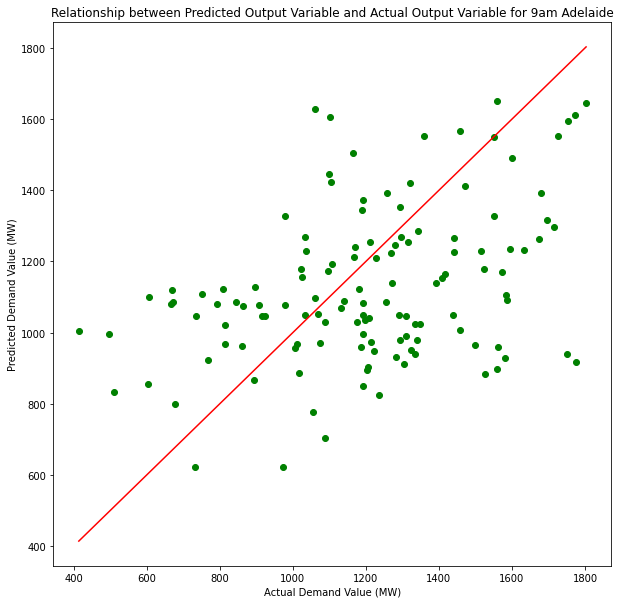

In [46]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

ax.scatter(Y_9am_test, y_9am_predict, c='g')

#plot the line y = x
x = np.linspace(min(Y_9am_test), max(Y_9am_test), 30)
ax.plot(x,x, 'r')
ax.set_xlabel("Actual Demand Value (MW)")
ax.set_ylabel("Predicted Demand Value (MW)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for 9am Adelaide')


plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the demand for 9am weather condition

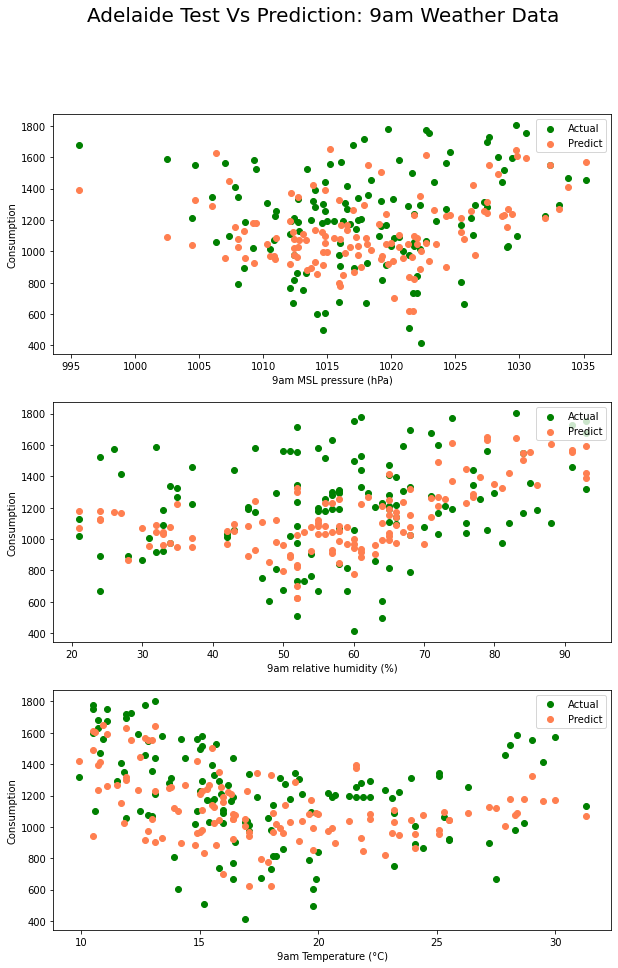

In [47]:
output_name = 'observing_predict_plot_9am_adei.png'
title = 'Adelaide Test Vs Prediction: 9am Weather Data'
observe_prediction(X_9am_test, Y_9am_test, y_9am_predict, title, output_name)

## 3pm Weather and Demand Relationship

In [48]:
#merge the demand at 9am to the weather dataset which is already pre-processed
merged_3pm_data = pd.merge(original_merged_data, sa_3pm, how='left')

#keeping 9am feature
feature_3pm = []

for col in merged_3pm_data:
    if '3pm' in col:
        feature_3pm.append(col)

#still keeping the totaldemand columns
feature_3pm.append("TOTALDEMAND")
merged_3pm_data = merged_3pm_data[feature_3pm]

#fill out some nan value due to the merge to the left 
#because the number of the date in weather data is more than demand data
merged_3pm_data['TOTALDEMAND'] = merged_3pm_data['TOTALDEMAND'].fillna(merged_3pm_data['TOTALDEMAND'].mean())

merged_3pm_data.head()

,3pm Temperature (°C),3pm relative humidity (%),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND
0,24.4,38,12.0,22.0,1013.9,639.64
1,23.7,33,9.0,20.0,1017.0,596.25
2,26.1,31,16.0,13.0,1009.2,723.20
3,19.1,73,6.0,17.0,998.9,954.00
4,18.5,73,7.0,30.0,994.5,1179.54


### Non Linear Relationship

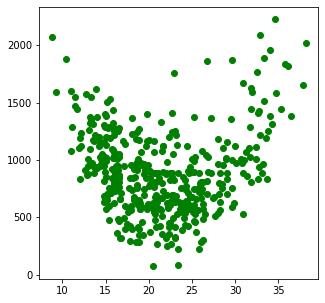

In [49]:
#create a subplot
plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()

ax.scatter(merged_3pm_data['3pm Temperature (°C)'], merged_3pm_data['TOTALDEMAND'], c='g')
plt.show()
plt.close()

## NMI for 3pm

In [50]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_3pm_data = merged_3pm_data.copy()
for name in merged_3pm_data:
    
    discrete_3pm_data[name] = equal_width.fit_transform(merged_3pm_data[[name]])

corr = discrete_3pm_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,3pm Temperature (°C),3pm relative humidity (%),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND
3pm Temperature (°C),1.000000,0.256068,0.135956,0.103558,0.173790,0.196151
3pm relative humidity (%),0.256068,1.000000,0.157308,0.111022,0.160705,0.160516
3pm wind direction,0.135956,0.157308,1.000000,0.128561,0.133068,0.134010
3pm wind speed (km/h),0.103558,0.111022,0.128561,1.000000,0.120182,0.122844
3pm MSL pressure (hPa),0.173790,0.160705,0.133068,0.120182,1.000000,0.153254
TOTALDEMAND,0.196151,0.160516,0.134010,0.122844,0.153254,1.000000


### Performing Mutual Information for feature selection

In [51]:
# get our features and class label
features = discrete_3pm_data[[x for x in discrete_3pm_data]]
class_label = discrete_3pm_data['TOTALDEMAND']

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "3pm Temperature (°C)": 0.5210
MI value for feature "3pm relative humidity (%)": 0.4292
MI value for feature "3pm wind direction": 0.3344
MI value for feature "3pm wind speed (km/h)": 0.2929
MI value for feature "3pm MSL pressure (hPa)": 0.3970
MI value for feature "TOTALDEMAND": 2.5717


In [52]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('3pm MSL pressure (hPa)', 0.39701092449646563),
 ('3pm relative humidity (%)', 0.4292169737224165),
 ('3pm Temperature (°C)', 0.5210395704629377),
 ('TOTALDEMAND', 2.5716712307758587)]

Selected Feature for Machine Learning are:
- 3pm MSL pressure (hPa)
- 3pm relative humidity (%)
- 3pm Temperature (°C)

### Apply KNN regressor for 3pm

In [53]:
features_3pm  = ['3pm MSL pressure (hPa)', '3pm relative humidity (%)', '3pm Temperature (°C)']

X_3pm = merged_3pm_data[features_3pm]
Y_3pm = merged_3pm_data['TOTALDEMAND']

In [54]:
#split the data into test and train
X_3pm_train, X_3pm_test, Y_3pm_train, Y_3pm_test = train_test_split(X_3pm,Y_3pm, test_size=0.3, random_state=21)

### Elbow method to find best value for k

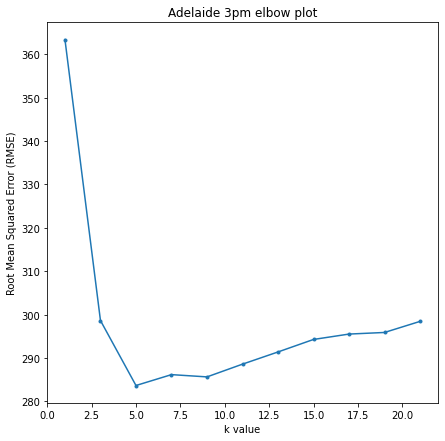

In [55]:
RMSE_3pm = []
for k in range(1,23,2):
    adei_3pm_knn_model = KNeighborsRegressor(n_neighbors=k)
    adei_3pm_knn_model.fit(X_3pm_train,Y_3pm_train)
    rmse_3pm = -cross_val_score(adei_3pm_knn_model, X_3pm_train, Y_3pm_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE_3pm.append(np.mean(rmse_3pm))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]

ax.plot(k,RMSE_3pm, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root Mean Squared Error (RMSE)")
ax.set_title('Adelaide 3pm elbow plot')

plt.show()
plt.close()

### Via elbow method, 5 will be the value for k for the KNN model

In [56]:
adei_3pm_knn_model = KNeighborsRegressor(n_neighbors=5)
adei_3pm_knn_model.fit(X_3pm_train,Y_3pm_train)

y_3pm_predict = adei_3pm_knn_model.predict(X_3pm_test)
print('r2: ', metrics.r2_score(Y_3pm_test, y_3pm_predict))
RMSE_3pm = math.sqrt(metrics.mean_squared_error(Y_3pm_test, y_3pm_predict))
print("RMSE: ",  RMSE_3pm)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE_3pm/np.mean(Y_3pm_test))*100), "%")
MAE_3pm = metrics.mean_absolute_error(Y_3pm_test, y_3pm_predict)
print("MAE: ", MAE_3pm)
print("Percentage of error compare to average of actual value: ", round((MAE_3pm/np.mean(Y_3pm_test))*100), "%")

r2:  0.3198298284542205
RMSE:  298.4404294452972
Percentage of RMSE compare to average of actual value:  34 %
MAE:  234.4676744283537
Percentage of error compare to average of actual value:  26 %


## Observing y actual vs y test graph for 3pm data

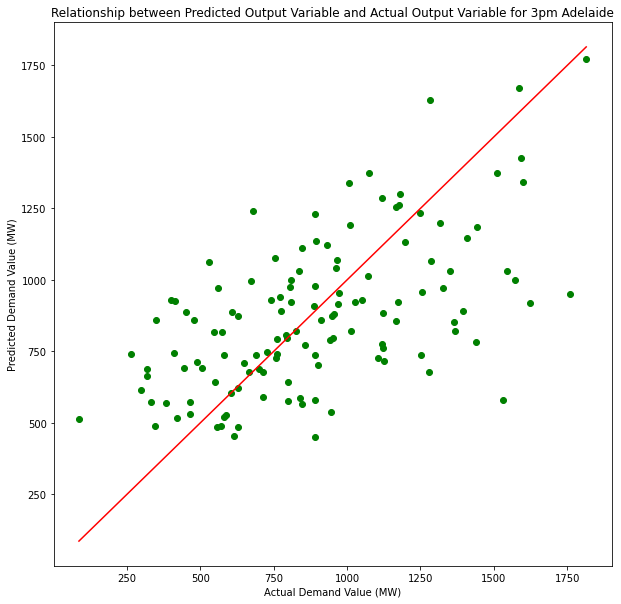

In [57]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

ax.scatter(Y_3pm_test, y_3pm_predict, c='g')

#plot the line y = x
x = np.linspace(min(Y_3pm_test), max(Y_3pm_test), 30)
ax.plot(x,x, 'r')

ax.set_xlabel("Actual Demand Value (MW)")
ax.set_ylabel("Predicted Demand Value (MW)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for 3pm Adelaide')

plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the demand for 9am weather condition

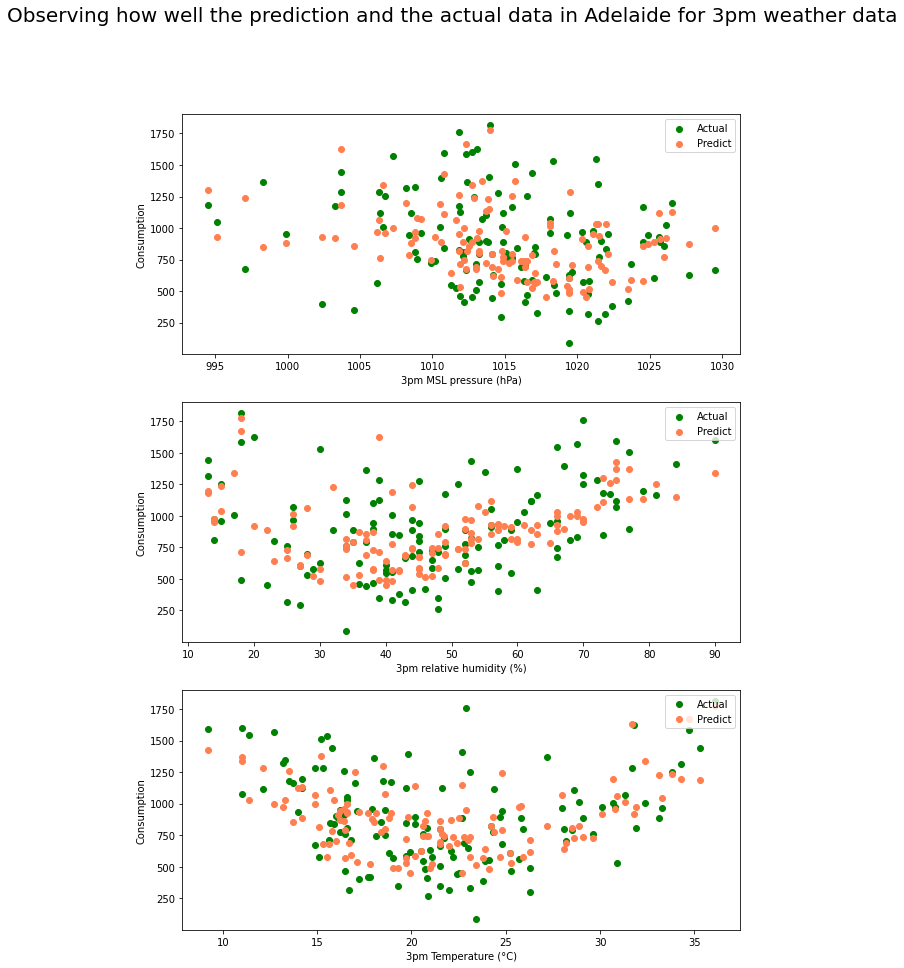

In [58]:
output_name = 'observing_predict_plot_3pm_adei.png'
title = 'Observing how well the prediction and the actual data in Adelaide for 3pm weather data'
observe_prediction(X_3pm_test, Y_3pm_test, y_3pm_predict, title, output_name)